In [1]:
# Constants for you to change
import os

DATA_DIRECTORY = '/home/younes'
LIVEJOURNAL_FILENAME = os.path.join(DATA_DIRECTORY, 'email-Enron.txt.gz')
LIVEJOURNAL_URL = 'http://snap.stanford.edu/data/email-Enron.txt.gz'

# Just have these hardcoded, though we don't really need to
NUM_EDGES = 367662
NUM_NODES = 36692

In [2]:
# Downloading the file

import urllib.request

assert os.path.exists(DATA_DIRECTORY)

# Get your data. This file is ~250M so it will take a bit
print('DOWNLOADING 250M FILE. WILL SAVE FOR FUTURE USE')
if not os.path.exists(LIVEJOURNAL_FILENAME):
    urllib.request.urlretrieve(LIVEJOURNAL_URL, LIVEJOURNAL_FILENAME)

# Show a little bit of the file
print('\nFILE STATS:')
!ls -lh $LIVEJOURNAL_FILENAME
print('\nSTARTING LINES')
!zcat $LIVEJOURNAL_FILENAME | head -n 30

DOWNLOADING 250M FILE. WILL SAVE FOR FUTURE USE

FILE STATS:
-rw-rw-r-- 1 younes younes 1.1M ماي 14 02:07 /home/younes/email-Enron.txt.gz

STARTING LINES
# Directed graph (each unordered pair of nodes is saved once): Email-Enron.txt 
# Enron email network (edge indicated that email was exchanged, undirected edges)
# Nodes: 36692 Edges: 367662
# FromNodeId	ToNodeId
0	1
1	0
1	2
1	3
1	4
1	5
1	6
1	7
1	8
1	9
1	10
1	11
1	12
1	13
1	14
1	15
1	16
1	17
1	18
1	19
1	20
1	21
1	22
1	23
1	24
1	25

gzip: stdout: Broken pipe


In [3]:
# Cleaning the data

import numpy as np
import gzip

def row_generator():
    """This will generate all the edges in the graph."""
    with gzip.open(LIVEJOURNAL_FILENAME, 'rt') as f:
        for line in f:
            if line.startswith('#'):
                continue
            else:
                (left_node, right_node) = line.split('\t')
                yield(int(left_node), int(right_node))

def to_undirected(edge_iterable, num_edges, num_nodes, shuffle=True):
    """Takes an iterable of edges and produces the list of edges for the undirected graph.
    
    > to_undirected([[0,1],[1,2],[2,10]], 3, 11)
    array([[ 0,  1],
       [ 1,  0],
       [ 1,  2],
       [ 2,  1],
       [ 2, 10],
       [10,  2]])
    """
    # need int64 to do gross bithacks
    as_array = np.zeros((num_edges, 2), dtype=np.int64)
    for (i, (n_0, n_1)) in enumerate(edge_iterable):
            as_array[i,0] = n_0
            as_array[i,1] = n_1
    # The graph is directed, but we want to make it undirected,
    # which means we will duplicate some rows.

    left_nodes = as_array[:,0]
    right_nodes = as_array[:,1]
    
    if shuffle:
        the_shuffle = np.arange(num_nodes)
        np.random.shuffle(the_shuffle)
        left_nodes = the_shuffle.take(left_nodes)
        right_nodes = the_shuffle.take(right_nodes)

    
    # numpy.unique will not unique whole rows, so this little bit-hacking
    # is a quick way to get unique rows after making a flipped copy of
    # each edge.
    max_bits = int(np.ceil(np.log2(num_nodes + 1)))
    
    encoded_edges_forward = np.left_shift(left_nodes, max_bits) | right_nodes
    
    # Flip the columns and do it again:
    encoded_edges_reverse = np.left_shift(right_nodes, max_bits) | left_nodes

    unique_encoded_edges = np.unique(np.hstack((encoded_edges_forward, encoded_edges_reverse)))
    
    left_node_decoded = np.right_shift(unique_encoded_edges, max_bits)
    
    # Mask out the high order bits
    right_node_decoded = (2 ** (max_bits) - 1) & unique_encoded_edges
    
    undirected_edges = np.vstack((left_node_decoded, right_node_decoded)).T.astype(np.int32)

    # ascontiguousarray so that it's c-contiguous for cython code below
    return np.ascontiguousarray(undirected_edges)


def get_clean_data(shuffle=True):
    if shuffle:
        name = os.path.join(DATA_DIRECTORY, 'LJ-mal-shuffled.npy')
    else:
        name = os.path.join(DATA_DIRECTORY, 'LJ-mal.npy')

    if os.path.exists(name):
        print('Loading from file {}'.format(name))
        return np.load(name)
    else:
        print('Parsing from zip. Will write to file {}'.format(name), flush=True)
        # Lets get the edges into one big array
        edges = to_undirected(row_generator(), NUM_EDGES, NUM_NODES, shuffle=shuffle)
        print('ORIGINAL DIST: {} MIN: {} MAX: {}'.format(np.abs(edges[:,0] - edges[:,1]).mean(), edges.min(), edges.max()))
        np.save(name, edges)
        return edges

In [4]:
print("Normalizing data (or loaded pre-computed)")
%time edges = get_clean_data(shuffle=True)
%time unshuffled_edges = get_clean_data(shuffle=False)
print('\nEDGES SHAPE: {}'.format(edges.shape))

Normalizing data (or loaded pre-computed)
Loading from file /home/younes/LJ-mal-shuffled.npy
CPU times: user 3.63 ms, sys: 0 ns, total: 3.63 ms
Wall time: 156 ms
Loading from file /home/younes/LJ-mal.npy
CPU times: user 2.25 ms, sys: 4.55 ms, total: 6.8 ms
Wall time: 73.6 ms

EDGES SHAPE: (367662, 2)


In [5]:
def score(assignment, edges):
    """Compute the score given an assignment of vertices.
    
    N nodes are assigned to clusters 0 to K-1.
    
    assignment: Vector where N[i] is the cluster node i is assigned to.
    edges: The edges in the graph, assumed to have one in each direction
    
    Returns: (total wasted bin space, ratio of edges cut)
    """
    balance = np.bincount(assignment) / len(assignment)
    waste = (np.max(balance) - balance).sum()
    
    left_edge_assignment = assignment.take(edges[:,0])
    right_edge_assignment = assignment.take(edges[:,1])
    mismatch = (left_edge_assignment != right_edge_assignment).sum()
    cut_ratio = mismatch / len(edges)
    return (waste, cut_ratio)

In [6]:
%load_ext cython
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [7]:
%%cython
import numpy as np
cimport cython

cdef int UNMAPPED = -1

def linear_deterministic_greedy(int[:,::] edges,
                                int num_nodes,
                                int num_partitions,
                                int[::] partition):
    """
    This algorithm favors a cluster if it has many neighbors of a node, but
    penalizes the cluster if it is close to capacity.
    
    edges: An [:,2] array of edges.
    num_nodes: The number of nodes in the graph.
    num_partitions: How many partitions we are breaking the graph into.
    partition: The partition from a previous run. Used for restreaming.

    Returns: A new partition.
    """
    # The output partition

    if partition is None:
        partition = np.repeat(np.int32(UNMAPPED), num_nodes)

    cdef int[::] partition_sizes = np.zeros(num_partitions, dtype=np.int32)
         
    cdef int[::] partition_votes = np.zeros(num_partitions, dtype=np.int32)
    
    # Fine to be a little off, to stay integers
    cdef int partition_capacity = num_nodes / num_partitions
    
    cdef int last_left = edges[0,0]
    cdef int i = 0
    cdef int left = 0
    cdef int right = 0
    cdef int arg = 0
    cdef int max_arg = 0
    cdef int max_val = 0
    cdef int val = 0
    cdef int len_edges = len(edges)
    
    for i in range(len_edges):
        left = edges[i,0]
        right = edges[i,1]
    
        if last_left != left:
            # We have found a new node so assign last_left to a partition
                
            max_arg = 0
            max_val = (partition_votes[0]) * (
                       partition_capacity - partition_sizes[0])

            for arg in range(1, num_partitions):
                val = (partition_votes[arg]) * (
                       partition_capacity - partition_sizes[arg])
                if val > max_val:
                    max_arg = arg
                    max_val = val

            if max_val == 0:
                max_arg = arg
                # No neighbors (or multiple maxed out) so "randomly" select
                # the smallest partition
                for arg in range(i % num_partitions, num_partitions):
                    if partition_sizes[arg] < partition_capacity:
                        max_arg = arg
                        max_val = 1
                        break
                if max_val == 0:
                    for arg in range(0, i % num_partitions):
                        if partition_sizes[arg] < partition_capacity:
                            max_arg = arg
                            break


            partition_sizes[max_arg] += 1
            partition[last_left] = max_arg
            partition_votes[:] = 0
            last_left = left

        if partition[right] != UNMAPPED:
            partition_votes[partition[right]] += 1


    # Clean up the last assignment
    max_arg = 0
    max_val = 0
    for arg in range(0, num_partitions):
        if partition_sizes[arg] < partition_capacity:
            val = (partition_votes[arg]) * (
                    1 - partition_sizes[arg] / partition_capacity)
            if val > max_val:
                max_arg = arg
                max_val = val
    partition[left] = max_arg

    return np.asarray(partition)

In [8]:
partition = None
%time partition = linear_deterministic_greedy(edges,NUM_NODES,2,partition)
%time wast,edge_cut = score(partition, edges)
print('wast='+str(1+wast)+' edge cut = '+str(edge_cut))

CPU times: user 2.83 ms, sys: 0 ns, total: 2.83 ms
Wall time: 2.89 ms
CPU times: user 4.46 ms, sys: 3.25 ms, total: 7.71 ms
Wall time: 6.59 ms
wast=1.0000545077946146 edge cut = 0.2684204513928554


In [9]:
partition = None
%time partition = linear_deterministic_greedy(edges,NUM_NODES,4,partition)
%time wast,edge_cut = score(partition, edges)
print('wast='+str(1+wast)+' edge cut = '+str(edge_cut))

CPU times: user 3.72 ms, sys: 0 ns, total: 3.72 ms
Wall time: 3.59 ms
CPU times: user 7.33 ms, sys: 0 ns, total: 7.33 ms
Wall time: 5.67 ms
wast=1.0001090155892292 edge cut = 0.454042027731993


In [10]:
partition = None
%time partition = linear_deterministic_greedy(edges,NUM_NODES,8,partition)
%time wast,edge_cut = score(partition, edges)
print('wast='+str(1+wast)+' edge cut = '+str(edge_cut))

CPU times: user 3.56 ms, sys: 0 ns, total: 3.56 ms
Wall time: 3.61 ms
CPU times: user 6.71 ms, sys: 0 ns, total: 6.71 ms
Wall time: 6.63 ms
wast=1.0005450779461462 edge cut = 0.5315751967840027


In [11]:
partition = None
%time partition = linear_deterministic_greedy(edges,NUM_NODES,16,partition)
%time wast,edge_cut = score(partition, edges)
print('wast='+str(1+wast)+' edge cut = '+str(edge_cut))

CPU times: user 6.08 ms, sys: 0 ns, total: 6.08 ms
Wall time: 6.19 ms
CPU times: user 3.09 ms, sys: 3.88 ms, total: 6.97 ms
Wall time: 6.99 ms
wast=1.0011991714815218 edge cut = 0.6135091469882664


In [12]:
partition = None
%time partition = linear_deterministic_greedy(edges,NUM_NODES,32,partition)
%time wast,edge_cut = score(partition, edges)
print('wast='+str(1+wast)+' edge cut = '+str(edge_cut))

CPU times: user 10.3 ms, sys: 0 ns, total: 10.3 ms
Wall time: 15.7 ms
CPU times: user 7.37 ms, sys: 0 ns, total: 7.37 ms
Wall time: 10.6 ms
wast=1.0160252916167012 edge cut = 0.6703711561162154


In [13]:
partition = None
%time partition = linear_deterministic_greedy(edges,NUM_NODES,40,partition)
%time wast,edge_cut = score(partition, edges)
print('wast='+str(1+wast)+' edge cut = '+str(edge_cut))

CPU times: user 9.88 ms, sys: 0 ns, total: 9.88 ms
Wall time: 9.89 ms
CPU times: user 7.48 ms, sys: 0 ns, total: 7.48 ms
Wall time: 7.78 ms
wast=1.0116646680475307 edge cut = 0.6984240960447368


In [16]:
def draw_figures(waste_values, edge_score_values, num_partitions):
    fig, axes = plt.subplots(nrows=1, ncols=2)
    
    (waste_axes, score_axes) = axes
    waste_axes.plot(waste_values, 'r')
    waste_axes.set_xlabel('Round')
    waste_axes.set_ylabel('Number of wasted bins')
    waste_axes.set_ylim(bottom=0)
    waste_axes.set_title('Wasted Bins: {} partitions'.format(num_partitions))
    
    score_axes.plot(edge_score_values, 'r')
    score_axes.set_xlabel('Round')
    score_axes.set_ylabel('Ratio of edges crossing partitions')
    score_axes.set_ylim(bottom=0)
    score_axes.set_title('Score: {} partitions'.format(num_partitions))
    
    fig.tight_layout()

In [15]:
def run_restreaming_greedy(edges, num_nodes, num_partitions=10, num_iterations=10):
    print('\n{} PARTITIONS'.format(num_partitions))
    assignments = None
    print('ROUND\tWASTE\tSCORE')
    waste_values = []
    edge_score_values = []
    flipped_edges = numpy.flipud(edges).copy()
    for i in range(num_iterations):
        assignments = linear_deterministic_greedy(edges, NUM_NODES, num_partitions, assignments)
        (waste, edge_score) = score(assignments, edges)
        waste_values.append(waste)
        edge_score_values.append(edge_score)
        print('{}\t{:0.3f}\t{:0.3f}'.format(i, waste, edge_score))
    draw_figures(waste_values, edge_score_values, num_partitions)


4 PARTITIONS
ROUND	WASTE	SCORE
0	0.000	0.454
1	0.000	0.307
2	0.000	0.283
3	0.000	0.265
4	0.000	0.259
5	0.000	0.255
6	0.000	0.254
7	0.000	0.254
8	0.000	0.253
9	0.000	0.253
10	0.000	0.253
11	0.000	0.253
12	0.000	0.253
13	0.000	0.253
14	0.000	0.253
15	0.000	0.253
16	0.000	0.253
17	0.000	0.253
18	0.000	0.253
19	0.000	0.253
CPU times: user 422 ms, sys: 107 ms, total: 529 ms
Wall time: 517 ms


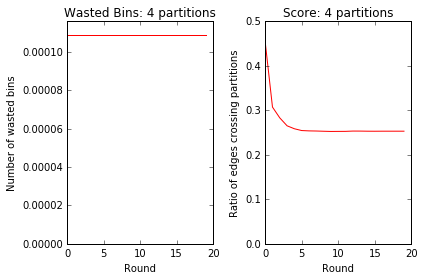

In [16]:
%time run_restreaming_greedy(edges, NUM_NODES, num_partitions=4, num_iterations=20)



2 PARTITIONS
ROUND	WASTE	SCORE
0	0.000	0.268
1	0.000	0.190
2	0.000	0.182
3	0.000	0.181
4	0.000	0.179
5	0.000	0.179
6	0.000	0.179
7	0.000	0.179
8	0.000	0.179
9	0.000	0.179
10	0.000	0.179
11	0.000	0.179
12	0.000	0.179
13	0.000	0.179
14	0.000	0.179
15	0.000	0.179
16	0.000	0.179
17	0.000	0.179
18	0.000	0.179
19	0.000	0.179
CPU times: user 486 ms, sys: 46.5 ms, total: 532 ms
Wall time: 519 ms


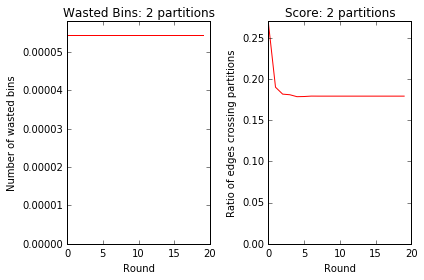

In [17]:
%time run_restreaming_greedy(edges, NUM_NODES, num_partitions=2, num_iterations=20)



8 PARTITIONS
ROUND	WASTE	SCORE
0	0.001	0.532
1	0.001	0.378
2	0.001	0.368
3	0.001	0.345
4	0.001	0.341
5	0.001	0.339
6	0.001	0.337
7	0.001	0.336
8	0.001	0.336
9	0.001	0.335
10	0.001	0.336
11	0.001	0.335
12	0.001	0.336
13	0.001	0.335
14	0.001	0.336
15	0.001	0.335
16	0.001	0.336
17	0.001	0.335
18	0.001	0.336
19	0.001	0.335
CPU times: user 498 ms, sys: 196 ms, total: 694 ms
Wall time: 587 ms


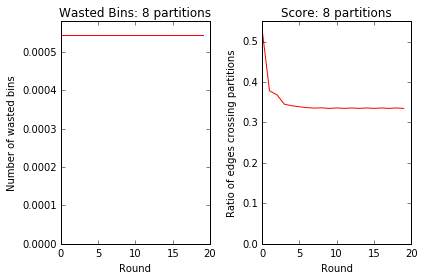

In [18]:
%time run_restreaming_greedy(edges, NUM_NODES, num_partitions=8, num_iterations=20)



16 PARTITIONS
ROUND	WASTE	SCORE
0	0.001	0.614
1	0.001	0.464
2	0.001	0.458
3	0.001	0.457
4	0.001	0.451
5	0.001	0.442
6	0.001	0.444
7	0.001	0.439
8	0.001	0.442
9	0.001	0.436
10	0.001	0.441
11	0.001	0.436
12	0.001	0.441
13	0.001	0.436
14	0.001	0.441
15	0.001	0.436
16	0.001	0.441
17	0.001	0.436
18	0.001	0.441
19	0.001	0.436
CPU times: user 467 ms, sys: 155 ms, total: 622 ms
Wall time: 559 ms


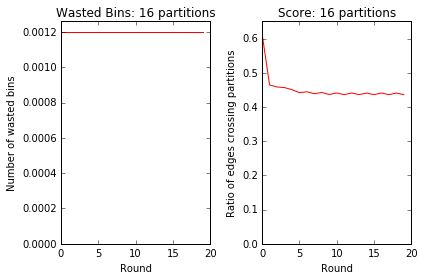

In [19]:
%time run_restreaming_greedy(edges, NUM_NODES, num_partitions=16, num_iterations=20)



32 PARTITIONS
ROUND	WASTE	SCORE
0	0.016	0.670
1	0.016	0.540
2	0.016	0.526
3	0.016	0.503
4	0.016	0.505
5	0.016	0.522
6	0.016	0.495
7	0.016	0.508
8	0.016	0.493
9	0.016	0.501
10	0.016	0.485
11	0.016	0.499
12	0.016	0.484
13	0.016	0.499
14	0.016	0.483
15	0.016	0.499
16	0.016	0.483
17	0.016	0.498
18	0.016	0.482
19	0.016	0.498
CPU times: user 521 ms, sys: 211 ms, total: 732 ms
Wall time: 620 ms


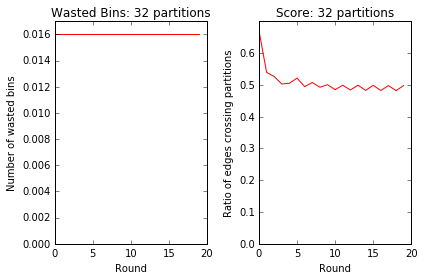

In [20]:
%time run_restreaming_greedy(edges, NUM_NODES, num_partitions=32, num_iterations=20)



40 PARTITIONS
ROUND	WASTE	SCORE
0	0.012	0.698
1	0.012	0.569
2	0.012	0.551
3	0.012	0.534
4	0.012	0.531
5	0.012	0.518
6	0.012	0.516
7	0.012	0.511
8	0.012	0.512
9	0.012	0.508
10	0.012	0.511
11	0.012	0.507
12	0.012	0.510
13	0.012	0.506
14	0.012	0.508
15	0.012	0.505
16	0.012	0.508
17	0.012	0.505
18	0.012	0.508
19	0.012	0.505
CPU times: user 542 ms, sys: 192 ms, total: 733 ms
Wall time: 648 ms


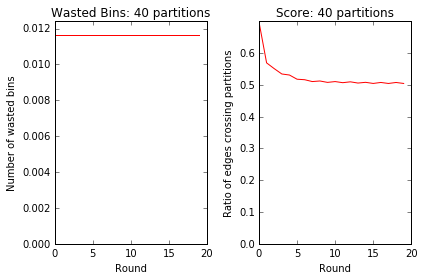

In [21]:
%time run_restreaming_greedy(edges, NUM_NODES, num_partitions=40, num_iterations=20)


In [13]:
%%cython
import numpy as np

cdef int UNMAPPED = -1

def fennel(int[:,::] edges,
           int num_nodes,
           int num_partitions,
           int[::] partition,
           float alpha):
    """
    This algorithm favors a cluster if it has many neighbors of a node, but
    penalizes the cluster if it is close to capacity.
    
    partition: A previous partition of the nodes. Set to -1's if a node has not been assigned.
    """
    
    cdef int[::] partition_sizes = None
    # The output partition
    if partition is None:
        partition = np.repeat(np.int32(UNMAPPED), num_nodes)
        partition_sizes = np.zeros(num_partitions, dtype=np.int32)
    else:
        partition_sizes = np.bincount(partition).astype(np.int32)
    
    cdef int[::] partition_votes = np.zeros(num_partitions, dtype=np.int32)
    
    cdef float partition_capacity = num_nodes / num_partitions
    
    cdef int last_left = edges[0,0]
    cdef int i = 0
    cdef int left = 0
    cdef int right = 0
    cdef int arg = 0
    cdef int max_arg = 0
    cdef float max_val = 0
    cdef float val = 0
    cdef int len_edges = len(edges)
    cdef int previous_assignment = 0

    for i in range(len_edges):
        left = edges[i,0]
        right = edges[i,1]
    
        if last_left != left:
            # New left node, so we have to assign last left

            # Remember placement of last_left in the previous assignment
            previous_assignment = partition[last_left]
            
            max_arg = 0
            max_val = partition_votes[0] - alpha * partition_sizes[0]
            if previous_assignment == 0:
                # We remove the node from its current partition before
                # deciding to re-add it, so subtract alpha to give
                # result of 1 lower partition size.
                max_val += alpha

            for arg in range(1, num_partitions):
                val = partition_votes[arg] - alpha * partition_sizes[arg]
                if previous_assignment == arg:
                    # See comment above
                    val += alpha
                if val > max_val:
                    max_arg = arg
                    max_val = val

            if max_arg != previous_assignment:
                partition[last_left] = max_arg
                partition_sizes[max_arg] += 1
                if previous_assignment != UNMAPPED:
                    partition_sizes[previous_assignment] -= 1

            partition_votes[:] = 0
            last_left = left

        if partition[right] != -1:
            partition_votes[partition[right]] += 1
    
    # TODO: finish off this fencepost....
    partition[left] = 0
    
    return np.asarray(partition)

In [23]:
assignment = None
%time assignment = fennel(edges,NUM_NODES,2,assignment,2.)
%time wast,edge_cut = score(assignment, edges)
print('wast='+str(1+wast)+' edge cut = '+str(edge_cut))

CPU times: user 4.75 ms, sys: 331 µs, total: 5.09 ms
Wall time: 6.79 ms
CPU times: user 2.69 ms, sys: 3.43 ms, total: 6.11 ms
Wall time: 6.13 ms
wast=1.0000545077946146 edge cut = 0.22968378565095116


In [24]:
assignment = None
%time assignment = fennel(edges,NUM_NODES,2,assignment,3.)
%time wast,edge_cut = score(assignment, edges)
print('wast='+str(1+wast)+' edge cut = '+str(edge_cut))

CPU times: user 2.23 ms, sys: 3.23 ms, total: 5.46 ms
Wall time: 14.9 ms
CPU times: user 4.82 ms, sys: 360 µs, total: 5.18 ms
Wall time: 5.76 ms
wast=1.0000545077946146 edge cut = 0.2266320696726885


In [25]:
assignment = None
%time assignment = fennel(edges,NUM_NODES,2,assignment,3.50)
%time wast,edge_cut = score(assignment, edges)
print('wast='+str(1+wast)+' edge cut = '+str(edge_cut))

CPU times: user 3.08 ms, sys: 1.87 ms, total: 4.95 ms
Wall time: 8.77 ms
CPU times: user 4.39 ms, sys: 175 µs, total: 4.57 ms
Wall time: 4.61 ms
wast=1.0000545077946146 edge cut = 0.222138812278669


In [26]:
assignment = None
%time assignment = fennel(edges,NUM_NODES,2,assignment,3.50)
%time wast,edge_cut = score(assignment, edges)
print('wast='+str(1+wast)+' edge cut = '+str(edge_cut))

CPU times: user 4.84 ms, sys: 0 ns, total: 4.84 ms
Wall time: 8.91 ms
CPU times: user 4.53 ms, sys: 0 ns, total: 4.53 ms
Wall time: 5.09 ms
wast=1.0000545077946146 edge cut = 0.222138812278669


In [27]:
assignment = None
%time assignment = fennel(edges,NUM_NODES,4,assignment,1.)
%time wast,edge_cut = score(assignment, edges)
print('wast='+str(1+wast)+' edge cut = '+str(edge_cut))

CPU times: user 6.08 ms, sys: 0 ns, total: 6.08 ms
Wall time: 12.3 ms
CPU times: user 5.37 ms, sys: 0 ns, total: 5.37 ms
Wall time: 5.78 ms
wast=1.0001090155892292 edge cut = 0.37141178582502404


In [28]:
assignment = None
%time assignment = fennel(edges,NUM_NODES,4,assignment,2.)
%time wast,edge_cut = score(assignment, edges)
print('wast='+str(1+wast)+' edge cut = '+str(edge_cut))

CPU times: user 5.82 ms, sys: 0 ns, total: 5.82 ms
Wall time: 9.69 ms
CPU times: user 5.31 ms, sys: 0 ns, total: 5.31 ms
Wall time: 5.33 ms
wast=1.0001090155892292 edge cut = 0.34639968231691065


In [29]:
assignment = None
%time assignment = fennel(edges,NUM_NODES,4,assignment,1.45)
%time wast,edge_cut = score(assignment, edges)
print('wast='+str(1+wast)+' edge cut = '+str(edge_cut))

CPU times: user 5.92 ms, sys: 0 ns, total: 5.92 ms
Wall time: 5.93 ms
CPU times: user 4.79 ms, sys: 0 ns, total: 4.79 ms
Wall time: 4.81 ms
wast=1.0001090155892292 edge cut = 0.3240421909253608


In [30]:
assignment = None
%time assignment = fennel(edges,NUM_NODES,4,assignment,1.35)
%time wast,edge_cut = score(assignment, edges)
print('wast='+str(1+wast)+' edge cut = '+str(edge_cut))

CPU times: user 5.23 ms, sys: 0 ns, total: 5.23 ms
Wall time: 8.35 ms
CPU times: user 4.65 ms, sys: 0 ns, total: 4.65 ms
Wall time: 5.13 ms
wast=1.0001090155892292 edge cut = 0.3239333953468131


In [31]:
assignment = None
%time assignment = fennel(edges,NUM_NODES,4,assignment,1.30)
%time wast,edge_cut = score(assignment, edges)
print('wast='+str(1+wast)+' edge cut = '+str(edge_cut))

CPU times: user 5.18 ms, sys: 0 ns, total: 5.18 ms
Wall time: 7.87 ms
CPU times: user 4.56 ms, sys: 0 ns, total: 4.56 ms
Wall time: 7.77 ms
wast=1.0001090155892292 edge cut = 0.3223014616685978


In [32]:
assignment = None
%time assignment = fennel(edges,NUM_NODES,4,assignment,1.25)
%time wast,edge_cut = score(assignment, edges)
print('wast='+str(1+wast)+' edge cut = '+str(edge_cut))

CPU times: user 5.61 ms, sys: 0 ns, total: 5.61 ms
Wall time: 12.5 ms
CPU times: user 4.62 ms, sys: 0 ns, total: 4.62 ms
Wall time: 5.32 ms
wast=1.0001090155892292 edge cut = 0.3223014616685978


In [33]:
assignment = None
%time assignment = fennel(edges,NUM_NODES,4,assignment,1.20)
%time wast,edge_cut = score(assignment, edges)
print('wast='+str(1+wast)+' edge cut = '+str(edge_cut))

CPU times: user 5.49 ms, sys: 633 µs, total: 6.12 ms
Wall time: 8.36 ms
CPU times: user 5.05 ms, sys: 0 ns, total: 5.05 ms
Wall time: 5.43 ms
wast=1.0001090155892292 edge cut = 0.3220512318379381


In [34]:
assignment = None
%time assignment = fennel(edges,NUM_NODES,4,assignment,1.15)
%time wast,edge_cut = score(assignment, edges)
print('wast='+str(1+wast)+' edge cut = '+str(edge_cut))

CPU times: user 5.06 ms, sys: 447 µs, total: 5.5 ms
Wall time: 5.52 ms
CPU times: user 5.27 ms, sys: 0 ns, total: 5.27 ms
Wall time: 7.84 ms
wast=1.0001090155892292 edge cut = 0.32155077217661876


In [35]:
assignment = None
%time assignment = fennel(edges,NUM_NODES,4,assignment,1.10)
%time wast,edge_cut = score(assignment, edges)
print('wast='+str(1+wast)+' edge cut = '+str(edge_cut))

CPU times: user 2.38 ms, sys: 3.32 ms, total: 5.7 ms
Wall time: 13.3 ms
CPU times: user 4.42 ms, sys: 178 µs, total: 4.6 ms
Wall time: 4.65 ms
wast=1.0001090155892292 edge cut = 0.32155077217661876


In [36]:
assignment = None
%time assignment = fennel(edges,NUM_NODES,4,assignment,1.05)
%time wast,edge_cut = score(assignment, edges)
print('wast='+str(1+wast)+' edge cut = '+str(edge_cut))

CPU times: user 5.19 ms, sys: 501 µs, total: 5.69 ms
Wall time: 11.3 ms
CPU times: user 5.25 ms, sys: 0 ns, total: 5.25 ms
Wall time: 5.69 ms
wast=1.0001090155892292 edge cut = 0.32155077217661876


In [37]:
assignment = None
%time assignment = fennel(edges,NUM_NODES,8,assignment,1.)
%time wast,edge_cut = score(assignment, edges)
print('wast='+str(1+wast)+' edge cut = '+str(edge_cut))

CPU times: user 6.34 ms, sys: 0 ns, total: 6.34 ms
Wall time: 6.31 ms
CPU times: user 4.62 ms, sys: 0 ns, total: 4.62 ms
Wall time: 4.96 ms
wast=1.0001090155892292 edge cut = 0.4601944176988647


In [38]:
assignment = None
%time assignment = fennel(edges,NUM_NODES,8,assignment,1.254228456)
%time wast,edge_cut = score(assignment, edges)
print('wast='+str(1+wast)+' edge cut = '+str(edge_cut))

CPU times: user 6.46 ms, sys: 0 ns, total: 6.46 ms
Wall time: 6.47 ms
CPU times: user 2.89 ms, sys: 1.2 ms, total: 4.1 ms
Wall time: 4.11 ms
wast=1.0001090155892292 edge cut = 0.48191001517698323


In [39]:
assignment = None
%time assignment = fennel(edges,NUM_NODES,16,assignment,1.)
%time wast,edge_cut = score(assignment, edges)
print('wast='+str(1+wast)+' edge cut = '+str(edge_cut))

CPU times: user 8.59 ms, sys: 0 ns, total: 8.59 ms
Wall time: 9.09 ms
CPU times: user 5.04 ms, sys: 0 ns, total: 5.04 ms
Wall time: 5.09 ms
wast=1.0011991714815218 edge cut = 0.5045014170624106


In [40]:
assignment = None
%time assignment = fennel(edges,NUM_NODES,32,assignment,1.)
%time wast,edge_cut = score(assignment, edges)
print('wast='+str(1+wast)+' edge cut = '+str(edge_cut))

CPU times: user 12.3 ms, sys: 0 ns, total: 12.3 ms
Wall time: 12.3 ms
CPU times: user 5.19 ms, sys: 0 ns, total: 5.19 ms
Wall time: 5.2 ms
wast=1.0073040444783603 edge cut = 0.569561173033928


In [41]:
assignment = None
%time assignment = fennel(edges,NUM_NODES,40,assignment,1.)
%time wast,edge_cut = score(assignment, edges)
print('wast='+str(1+wast)+' edge cut = '+str(edge_cut))

CPU times: user 14.3 ms, sys: 72 µs, total: 14.4 ms
Wall time: 16.9 ms
CPU times: user 5.3 ms, sys: 0 ns, total: 5.3 ms
Wall time: 5.32 ms
wast=1.0062138885860679 edge cut = 0.5790807861568505


In [42]:
assignment = None
%time assignment = fennel(edges,NUM_NODES,40,assignment,1.15)
%time wast,edge_cut = score(assignment, edges)
print('wast='+str(1+wast)+' edge cut = '+str(edge_cut))

CPU times: user 17.5 ms, sys: 0 ns, total: 17.5 ms
Wall time: 22 ms
CPU times: user 5.63 ms, sys: 0 ns, total: 5.63 ms
Wall time: 6.23 ms
wast=1.00294342090919 edge cut = 0.6384342140335417


In [58]:
def run_fennel_restreaming(edges, num_nodes, num_partitions, num_iterations):
    print('{} PARTITIONS'.format(num_partitions))
    assignments = None
    # We will explore this parameter in a future post. This is sub-optimal
    alphas = np.linspace(1.251608191745264e-05, 1.588951557309824e-03, num_iterations)
    waste_scores, edge_score_values = [], []
    print('ROUND\tALPHA\tWASTE\tSCORE')
    for i in range(num_iterations):
        alpha = alphas[i]
        assignments = fennel(edges, NUM_NODES, num_partitions, assignments, alpha)
        (waste, edge_score) = score(assignments, edges)
        print('{}\t{:.1e}\t{:0.3f}\t{:0.3f}'.format(i, alpha, waste, edge_score))
        waste_scores.append(waste)
        edge_score_values.append(edge_score)
    draw_figures(waste_scores, edge_score_values, num_partitions)

# k = 2

2 PARTITIONS
ROUND	ALPHA	WASTE	SCORE
0	1.3e+00	0.000	0.253
1	1.6e+00	0.000	0.182
2	1.9e+00	0.000	0.166
3	2.3e+00	0.000	0.154
4	2.6e+00	0.000	0.146
5	2.9e+00	0.000	0.144
6	3.3e+00	0.000	0.143
7	3.6e+00	0.000	0.142
8	3.9e+00	0.000	0.141
9	4.3e+00	0.000	0.141
10	4.6e+00	0.000	0.141
11	4.9e+00	0.000	0.140
12	5.3e+00	0.000	0.140
13	5.6e+00	0.000	0.140
14	5.9e+00	0.000	0.140
15	6.3e+00	0.000	0.140
16	6.6e+00	0.000	0.140
17	6.9e+00	0.000	0.140
18	7.3e+00	0.000	0.140
19	7.6e+00	0.000	0.140
CPU times: user 370 ms, sys: 61.6 ms, total: 431 ms
Wall time: 444 ms


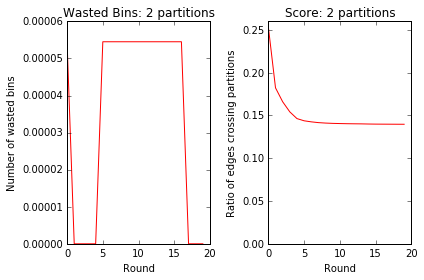

In [44]:
%time run_fennel_restreaming(edges, NUM_NODES, 2, 20)


2 PARTITIONS
ROUND	ALPHA	WASTE	SCORE
0	1.3e-07	0.001	0.228
1	4.1e-06	0.001	0.155
2	8.1e-06	0.000	0.145
3	1.2e-05	0.000	0.142
4	1.6e-05	0.000	0.141
5	2.0e-05	0.000	0.141
6	2.4e-05	0.000	0.140
7	2.8e-05	0.000	0.140
8	3.2e-05	0.002	0.137
9	3.6e-05	0.003	0.135
10	4.0e-05	0.001	0.134
11	4.4e-05	0.001	0.134
12	4.8e-05	0.001	0.134
13	5.2e-05	0.002	0.134
14	5.6e-05	0.002	0.134
15	6.0e-05	0.002	0.134
16	6.4e-05	0.002	0.134
17	6.8e-05	0.002	0.134
18	7.2e-05	0.002	0.134
19	7.6e-05	0.002	0.134
CPU times: user 420 ms, sys: 99 ms, total: 519 ms
Wall time: 412 ms


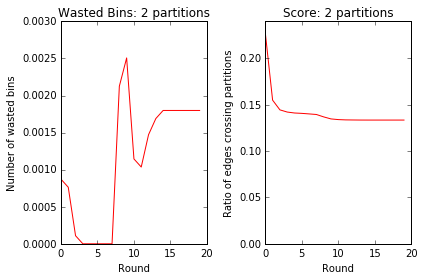

In [19]:
%time run_fennel_restreaming(edges, NUM_NODES, 2, 20)


# k = 4

4 PARTITIONS
ROUND	ALPHA	WASTE	SCORE
0	1.3e+00	0.000	0.371
1	1.6e+00	0.000	0.227
2	1.9e+00	0.000	0.194
3	2.3e+00	0.000	0.183
4	2.6e+00	0.000	0.178
5	2.9e+00	0.000	0.175
6	3.3e+00	0.000	0.173
7	3.6e+00	0.000	0.172
8	3.9e+00	0.000	0.172
9	4.3e+00	0.000	0.171
10	4.6e+00	0.000	0.171
11	4.9e+00	0.000	0.170
12	5.3e+00	0.000	0.170
13	5.6e+00	0.000	0.170
14	5.9e+00	0.000	0.170
15	6.3e+00	0.000	0.170
16	6.6e+00	0.000	0.170
17	6.9e+00	0.000	0.170
18	7.3e+00	0.000	0.170
19	7.6e+00	0.000	0.170
CPU times: user 501 ms, sys: 219 ms, total: 720 ms
Wall time: 526 ms


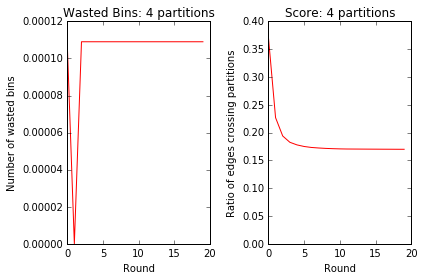

In [45]:
%time run_fennel_restreaming(edges, NUM_NODES, 4, 20)


4 PARTITIONS
ROUND	ALPHA	WASTE	SCORE
0	1.3e-07	0.531	0.250
1	4.1e-06	1.339	0.073
2	8.1e-06	1.435	0.054
3	1.2e-05	1.457	0.051
4	1.6e-05	1.463	0.049
5	2.0e-05	1.464	0.049
6	2.4e-05	1.464	0.049
7	2.8e-05	1.464	0.049
8	3.2e-05	1.464	0.049
9	3.6e-05	1.464	0.049
10	4.0e-05	1.464	0.049
11	4.4e-05	1.464	0.049
12	4.8e-05	1.464	0.049
13	5.2e-05	1.464	0.049
14	5.6e-05	1.408	0.052
15	6.0e-05	1.342	0.055
16	6.4e-05	1.277	0.058
17	6.8e-05	1.204	0.061
18	7.2e-05	1.136	0.065
19	7.6e-05	1.077	0.067
CPU times: user 385 ms, sys: 137 ms, total: 522 ms
Wall time: 391 ms


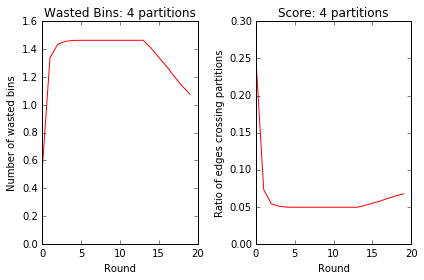

In [24]:
%time run_fennel_restreaming(edges, NUM_NODES, 4, 20)


# k= 8

8 PARTITIONS
ROUND	ALPHA	WASTE	SCORE
0	1.3e+00	0.000	0.460
1	1.6e+00	0.000	0.340
2	1.9e+00	0.000	0.310
3	2.3e+00	0.000	0.294
4	2.6e+00	0.000	0.285
5	2.9e+00	0.000	0.279
6	3.3e+00	0.000	0.273
7	3.6e+00	0.000	0.269
8	3.9e+00	0.000	0.268
9	4.3e+00	0.001	0.267
10	4.6e+00	0.001	0.266
11	4.9e+00	0.000	0.265
12	5.3e+00	0.000	0.265
13	5.6e+00	0.000	0.264
14	5.9e+00	0.000	0.264
15	6.3e+00	0.000	0.263
16	6.6e+00	0.000	0.263
17	6.9e+00	0.000	0.263
18	7.3e+00	0.000	0.263
19	7.6e+00	0.000	0.263
CPU times: user 394 ms, sys: 85 ms, total: 479 ms
Wall time: 376 ms


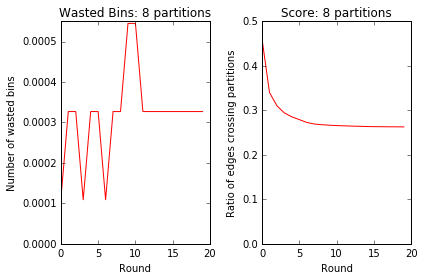

In [46]:
%time run_fennel_restreaming(edges, NUM_NODES, 8, 20)


8 PARTITIONS
ROUND	ALPHA	WASTE	SCORE
0	1.3e-07	0.251	0.422
1	4.1e-06	0.843	0.263
2	8.1e-06	0.943	0.236
3	1.2e-05	1.015	0.223
4	1.6e-05	1.081	0.210
5	2.0e-05	1.115	0.205
6	2.4e-05	1.123	0.203
7	2.8e-05	1.126	0.203
8	3.2e-05	1.129	0.203
9	3.6e-05	1.130	0.202
10	4.0e-05	1.130	0.202
11	4.4e-05	1.130	0.202
12	4.8e-05	1.130	0.202
13	5.2e-05	1.130	0.202
14	5.6e-05	1.130	0.202
15	6.0e-05	1.130	0.202
16	6.4e-05	1.130	0.202
17	6.8e-05	1.130	0.202
18	7.2e-05	1.130	0.202
19	7.6e-05	1.130	0.202
CPU times: user 388 ms, sys: 120 ms, total: 508 ms
Wall time: 379 ms


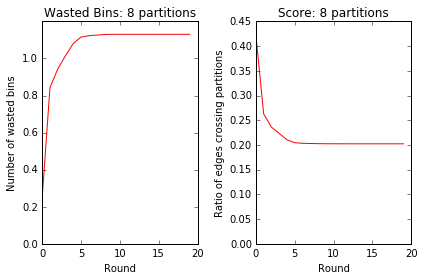

In [25]:
%time run_fennel_restreaming(edges, NUM_NODES, 8, 20)


# k= 16

16 PARTITIONS
ROUND	ALPHA	WASTE	SCORE
0	1.3e+00	0.001	0.505
1	1.6e+00	0.003	0.384
2	1.9e+00	0.003	0.365
3	2.3e+00	0.003	0.357
4	2.6e+00	0.003	0.353
5	2.9e+00	0.003	0.351
6	3.3e+00	0.003	0.350
7	3.6e+00	0.003	0.349
8	3.9e+00	0.003	0.348
9	4.3e+00	0.003	0.348
10	4.6e+00	0.003	0.348
11	4.9e+00	0.003	0.347
12	5.3e+00	0.003	0.347
13	5.6e+00	0.003	0.347
14	5.9e+00	0.003	0.347
15	6.3e+00	0.003	0.347
16	6.6e+00	0.003	0.347
17	6.9e+00	0.003	0.347
18	7.3e+00	0.003	0.347
19	7.6e+00	0.003	0.346
CPU times: user 435 ms, sys: 88.1 ms, total: 523 ms
Wall time: 407 ms


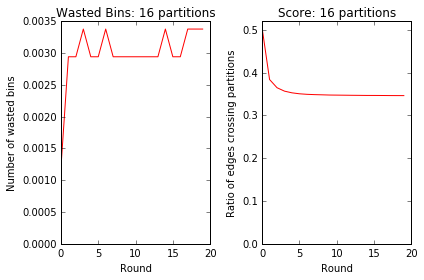

In [47]:
%time run_fennel_restreaming(edges, NUM_NODES, 16, 20)


16 PARTITIONS
ROUND	ALPHA	WASTE	SCORE
0	1.3e-05	1.071	0.444
1	9.5e-05	2.907	0.279
2	1.8e-04	2.163	0.266
3	2.6e-04	2.208	0.251
4	3.4e-04	2.257	0.240
5	4.3e-04	2.154	0.226
6	5.1e-04	2.344	0.196
7	5.9e-04	2.028	0.202
8	6.8e-04	1.995	0.202
9	7.6e-04	1.984	0.201
10	8.4e-04	1.907	0.203
11	9.3e-04	1.724	0.208
12	1.0e-03	1.589	0.213
13	1.1e-03	1.558	0.214
14	1.2e-03	1.550	0.214
15	1.3e-03	1.547	0.214
16	1.3e-03	1.486	0.218
17	1.4e-03	1.388	0.223
18	1.5e-03	1.326	0.226
19	1.6e-03	1.260	0.230
CPU times: user 374 ms, sys: 88.9 ms, total: 463 ms
Wall time: 356 ms


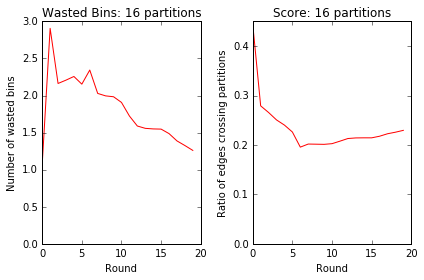

In [42]:
%time run_fennel_restreaming(edges, NUM_NODES, 16, 20)


# k=32

32 PARTITIONS
ROUND	ALPHA	WASTE	SCORE
0	1.3e+00	0.007	0.570
1	1.6e+00	0.011	0.462
2	1.9e+00	0.008	0.437
3	2.3e+00	0.007	0.428
4	2.6e+00	0.008	0.423
5	2.9e+00	0.008	0.421
6	3.3e+00	0.007	0.420
7	3.6e+00	0.008	0.419
8	3.9e+00	0.008	0.418
9	4.3e+00	0.008	0.418
10	4.6e+00	0.008	0.417
11	4.9e+00	0.008	0.417
12	5.3e+00	0.008	0.417
13	5.6e+00	0.009	0.417
14	5.9e+00	0.009	0.417
15	6.3e+00	0.009	0.417
16	6.6e+00	0.009	0.417
17	6.9e+00	0.009	0.417
18	7.3e+00	0.009	0.417
19	7.6e+00	0.009	0.417
CPU times: user 449 ms, sys: 81.1 ms, total: 530 ms
Wall time: 418 ms


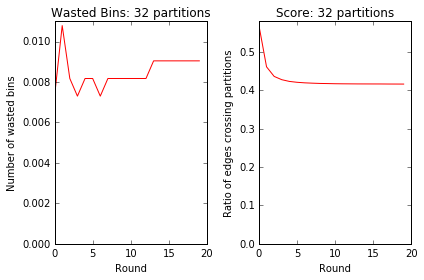

In [48]:
%time run_fennel_restreaming(edges, NUM_NODES, 32, 20)


32 PARTITIONS
ROUND	ALPHA	WASTE	SCORE
0	1.3e-05	6.006	0.400
1	9.5e-05	9.301	0.177
2	1.8e-04	8.917	0.150
3	2.6e-04	7.684	0.155
4	3.4e-04	7.240	0.158
5	4.3e-04	6.250	0.175
6	5.1e-04	6.126	0.176
7	5.9e-04	5.539	0.189
8	6.8e-04	4.929	0.202
9	7.6e-04	4.783	0.205
10	8.4e-04	4.754	0.206
11	9.3e-04	4.441	0.214
12	1.0e-03	4.098	0.224
13	1.1e-03	3.845	0.231
14	1.2e-03	3.798	0.233
15	1.3e-03	3.786	0.233
16	1.3e-03	3.716	0.235
17	1.4e-03	3.441	0.244
18	1.5e-03	3.293	0.248
19	1.6e-03	3.132	0.253
CPU times: user 439 ms, sys: 107 ms, total: 546 ms
Wall time: 439 ms


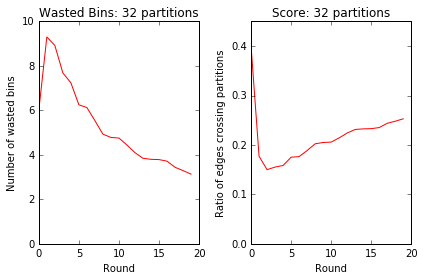

In [43]:
%time run_fennel_restreaming(edges, NUM_NODES, 32, 20)


32 PARTITIONS
ROUND	ALPHA	WASTE	SCORE
0	1.3e-05	6.006	0.400
1	6.7e-05	12.535	0.154
2	1.2e-04	9.370	0.143
3	1.8e-04	9.562	0.131
4	2.3e-04	8.088	0.146
5	2.8e-04	7.996	0.146
6	3.4e-04	7.312	0.157
7	3.9e-04	6.390	0.172
8	4.5e-04	6.282	0.173
9	5.0e-04	6.224	0.174
10	5.6e-04	5.948	0.180
11	6.1e-04	5.404	0.192
12	6.6e-04	5.004	0.200
13	7.2e-04	4.852	0.203
14	7.7e-04	4.821	0.204
15	8.3e-04	4.814	0.204
16	8.8e-04	4.703	0.207
17	9.4e-04	4.371	0.216
18	9.9e-04	4.184	0.221
19	1.0e-03	3.978	0.227
20	1.1e-03	3.849	0.230
21	1.2e-03	3.818	0.231
22	1.2e-03	3.812	0.231
23	1.3e-03	3.809	0.231
24	1.3e-03	3.810	0.231
25	1.4e-03	3.563	0.239
26	1.4e-03	3.481	0.241
27	1.5e-03	3.353	0.245
28	1.5e-03	3.243	0.248
29	1.6e-03	3.140	0.251
CPU times: user 681 ms, sys: 130 ms, total: 811 ms
Wall time: 681 ms


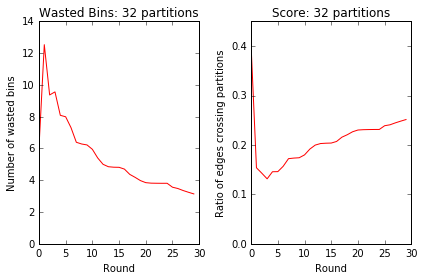

In [59]:
%time run_fennel_restreaming(edges, NUM_NODES, 32, 30)


In [120]:
alphas

array([1.25160819e-07])